# Môn học: Xử lý Ngôn ngữ Tự nhiên (HK2 24-25)
Giảng viên: ThS. Huỳnh Thanh Sơn
# Thành viên nhóm:
* Trần Trọng Kiên (MSSV: 22110093)
* Trương Hồng Kiệt (MSSV: 22110096)
* Vũ Diệu Minh (MSSV: 22110118)

# **Final Project**

##**Problem stament :**     

The widespread dissemination of fake news and propaganda presents serious societal risks, including the erosion of public trust, political polarization, manipulation of elections, and the spread of harmful misinformation during crises such as pandemics or conflicts. From an NLP perspective, detecting fake news is fraught with challenges. Linguistically, fake news often mimics the tone and structure of legitimate journalism, making it difficult to distinguish using surface-level features. The absence of reliable and up-to-date labeled datasets, especially across multiple languages and regions, hampers the effectiveness of supervised learning models. Additionally, the dynamic and adversarial nature of misinformation means that malicious actors constantly evolve their language and strategies to bypass detection systems. Cultural context, sarcasm, satire, and implicit bias further complicate automated analysis. Moreover, NLP models risk amplifying biases present in training data, leading to unfair classifications and potential censorship of legitimate content. These challenges underscore the need for cautious, context-aware approaches, as the failure to address them can inadvertently contribute to misinformation, rather than mitigate it.



Use datasets in link : https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing
to complete requirement.

## **About dataset:**

* **True Articles**:

  * **File**: `MisinfoSuperset_TRUE.csv`
  * **Sources**:

    * Reputable media outlets like **Reuters**, **The New York Times**, **The Washington Post**, etc.

* **Fake/Misinformation/Propaganda Articles**:

  * **File**: `MisinfoSuperset_FAKE.csv`
  * **Sources**:

    * **American right-wing extremist websites** (e.g., Redflag Newsdesk, Breitbart, Truth Broadcast Network)
    * **Public dataset** from:

      * Ahmed, H., Traore, I., & Saad, S. (2017): "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques" *(Springer LNCS 10618)*



## **Requirement**

A team consisting of three members must complete a project that involves applying the methods learned from the beginning of the course up to the present. The team is expected to follow and document the entire machine learning workflow, which includes the following steps:

1. **Data Preprocessing**: Clean and prepare the dataset,etc.

2. **Exploratory Data Analysis (EDA)**: Explore and visualize the data.

3. **Model Building**: Select and build one or more machine learning models suitable for the problem at hand.

4. **Hyperparameter set up**: Set and adjust the model's hyperparameters using appropriate methods to improve performance.

5. **Model Training**: Train the model(s) on the training dataset.

6. **Performance Evaluation**: Evaluate the trained model(s) using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) and validate their performance on unseen data.

7. **Conclusion**: Summarize the results, discuss the model's strengths and weaknesses, and suggest possible improvements or future work.





# 0. Thư viện

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/datasets.git

  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-i5w98i3f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets.git /tmp/pip-req-build-i5w98i3f
  Resolved https://github.com/huggingface/datasets.git to commit b7819cd9f7a51a83389d435c5a8ffe450890a3bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.9 MB/s eta 0:00:00
  Created wheel for datasets: filename=datasets-4.0.0.dev0-py3-none-any.whl size=494554 sha256=45a4524fb622e61840c7f97d164ebbf116b3458e9dc88f0a5bc17ea1f12c2eae
  Stored in directory: /tmp/pip-ephem-wheel-cache-72npnqud/wheels/33/07/5d/35c54571205e7fce2b7600c936fd1d5c558c1b7ea98e86e0e1
Successfully built datasets
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
import os
import gdown
import zipfile
from sklearn.model_selection import train_test_split
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import gc
import psutil
from typing import List
import spacy

# 1. Data

In [ ]:
file_id = "1BhaOQU5wYDL8IxOzgvZM-IlgYfJf3HFD"
output = "true.zip"
gdown.download(id=file_id, output=output, quiet=False)

file_id = "1aA9o8PJ-9gYAcLaaxLmXUrxlrHtArlrh"
output = "fake.zip"
gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1BhaOQU5wYDL8IxOzgvZM-IlgYfJf3HFD
From (redirected): https://drive.google.com/uc?id=1BhaOQU5wYDL8IxOzgvZM-IlgYfJf3HFD&confirm=t&uuid=8304ba42-eada-4081-a26a-1c66fd7184a2
To: /content/true.zip
100%|██████████| 43.0M/43.0M [00:00<00:00, 92.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1aA9o8PJ-9gYAcLaaxLmXUrxlrHtArlrh
From (redirected): https://drive.google.com/uc?id=1aA9o8PJ-9gYAcLaaxLmXUrxlrHtArlrh&confirm=t&uuid=6a99885c-6a04-46a6-951a-3e068018f014
To: /content/fake.zip
100%|██████████| 45.1M/45.1M [00:00<00:00, 93.7MB/s]


'fake.zip'

In [ ]:
with zipfile.ZipFile("true.zip", 'r') as zip_ref:
    zip_ref.extractall("true")

with zipfile.ZipFile("fake.zip", 'r') as zip_ref:
    zip_ref.extractall("fake")

## Data preprocessing

Đọc dữ liệu từ hai file csv, tạo thêm cột label tương ứng và kết hợp hai data frame với nhau

In [ ]:
df_true = pd.read_csv("/content/true/DataSet_Misinfo_TRUE.csv", usecols=['text'])
df_fake = pd.read_csv("/content/fake/DataSet_Misinfo_FAKE.csv",usecols=['text'])

df_true['label'] = 1
df_fake['label'] = 0

df = pd.concat([df_true, df_fake], ignore_index=True)

print(f"Total samples: {len(df)}")
display(df.sample(10))

Total samples: 78617


,text,label
76750,Poroshenko - with the support from the USA and...,0
12219,Kremlin spokesman Dmitry Peskov said on Friday...,1
59801,Waking Times \n“In the middle of all the brain...,0
17519,Russia said on Friday after U.S. President Don...,1
1198,U.S. President Donald Trump said on Tuesday he...,1
34362,WASHINGTON — FBI Director James Comey said Fri...,1
69557,Ask Holly: What's everyone's problem? 27-10-16...,0
36426,Already demonstrating her inability to keep he...,0
8132,Hillary Clinton got back on the campaign trail...,1
15876,Russia has sold its advanced S-400 air defense...,1


Kiểm tra dữ liệu

Datatype of each column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78617 entries, 0 to 78616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None
Null value:
text     29
label     0
dtype: int64
Duplicate:
10012


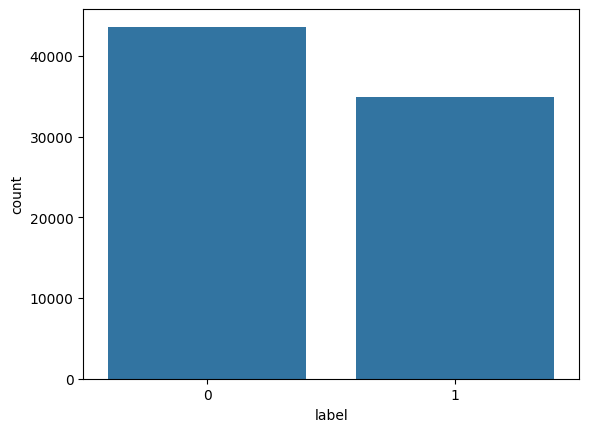

In [ ]:
# Data analysis

# Datatype
print("Datatype of each column:")
print(df.info())
print("===="*25)

# Null checking
print("Null value:")
print(df.isnull().sum())
print("===="*25)

# Duplicate checking
print("Duplicate:")
print(df.duplicated().sum())
print("===="*25)

# Number of each target class
sns.countplot(data=df, x='label');

Sau khi kiểm tra, ta thấy dữ liệu bị khuyết ở 29 dòng và bị lặp 10012, do đó ta thực hiện tiền xử lý dữ liệu:
* Xoá các dòng bị khuyết
* Xoá các dòng bị lặp

In [ ]:
def preprocessing_data(df):
    df = df.dropna(inplace=False)
    df = df.drop_duplicates(inplace=False)
    return df

In [ ]:
df = preprocessing_data(df.copy())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68604 entries, 0 to 78616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68604 non-null  object
 1   label   68604 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


## Khám phá dữ liệu (EDA)

### Kiểm tra lại phân phối của hai lớp sau khi tiền xử lý dữ liệu

Class distribution:
label
0    34078
1    34526
Name: count, dtype: int64


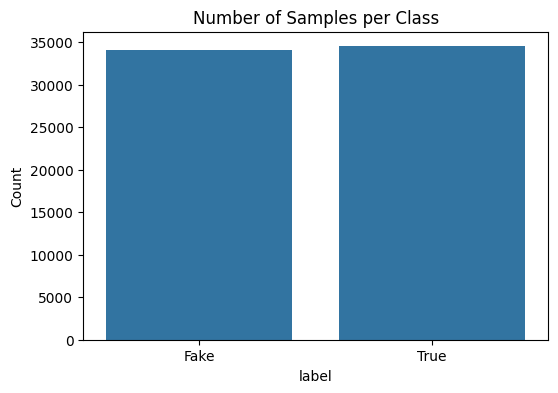

In [ ]:
class_counts = df['label'].value_counts().sort_index()
print("Class distribution:")
print(class_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0,1], ['Fake','True'])
plt.title('Number of Samples per Class')
plt.ylabel('Count')
plt.show()

### Thống kê tóm tắt

In [ ]:
df['char_len'] = df['text'].apply(len) # Character lengths
df['word_len'] = df['text'].apply(lambda x: len(x.split())) # Word lengths

In [ ]:
# Summary statistics
print(df.groupby('label')[['char_len','word_len']].describe().T)

label                       0             1
char_len count   34078.000000  34526.000000
         mean     2572.791566   3245.167439
         std      3749.823330   3346.698458
         min         1.000000      3.000000
         25%       589.000000   1109.000000
         50%      1976.000000   2408.000000
         75%      3057.750000   4397.000000
         max    142961.000000  85948.000000
word_len count   34078.000000  34526.000000
         mean      426.675685    537.157302
         std       625.342871    567.222748
         min         1.000000      1.000000
         25%        97.000000    181.000000
         50%       331.000000    391.000000
         75%       509.000000    724.750000
         max     24234.000000  14641.000000


Dựa vào bảng thống kê tóm tắt, ta có thể rút ra một số nhận xét quan trọng về khác biệt giữa hai nhóm "Fake" (label 0) và "True" (label 1):

1. **Kích thước trung bình**

   * Độ dài tính theo ký tự (char\_len): trung bình Fake ~ 2 573 ký tự, True ~ 3 245 ký tự.
   * Độ dài tính theo số từ (word\_len): trung bình Fake ~ 427 từ, True ~ 537 từ.

     -> Các bài true nhìn chung dài hơn hẳn so với fake (hơn \~25 % về số từ), điều này có thể cho thấy rằng tin thật thường được khai thác nội dung sâu hơn, chi tiết hơn.

2. **Phân bố và độ lệch**

   * Độ lệch chuẩn (std) của cả hai lớp đều khá lớn (hơn 3 000 ký tự / hơn 500 từ), cho thấy có độ đa dạng cao về độ dài bài. Tuy nhiên lớp Fake có độ lệch chuẩn về char\_len còn cao hơn so với lớp True, nghĩa là độ dài các bài fake rất không đồng đều: có những bài cực kỳ ngắn (min = 1 ký tự) và cũng có những bài rất dài (max = 142 961 ký tự).
   * Range của lớp Fake cũng dài hơn (từ 1 tới 142 961 ký tự) so với True (3 tới 85 948 ký tự).

3. **Percentiles**

   * **25%**: 25% bài Fake có $\leq$ 589 ký tự (\~97 từ), trong khi 25% bài True đã có $\geq$ 1 109 ký tự (\~181 từ).
   * **50% (median)**: bài Fake giữa nhóm dài \~1 976 ký tự (331 từ), bài True \~2 408 ký tự (391 từ).
   * **75%**: 75% bài Fake $\leq$ 3 058 ký tự (509 từ), nhưng 75% bài True $\leq$ 4 397 ký tự (725 từ).
     
     -> Nhìn vào median và quartiles, toàn bộ phân vị của lớp True đều cao hơn lớp Fake, minh chứng mạnh mẽ cho việc bài True thường dài hơn, nội dung dày dặn hơn.

4. **Outliers**

   * Cả hai lớp đều có outliers (những bài cực ngắn hoặc cực dài). Những bài cực ngắn (1–3 từ) khả năng là noise hoặc lỗi (ví dụ record trống hoặc chỉ tiêu đề). Những bài cực dài (đến cả chục nghìn từ) có thể gây ảnh hưởng lớn lên vector hóa TF-IDF và cả thời gian train.

**Kết luận & gợi ý xử lý tiếp**

* Có sự khác biệt rõ ràng về độ dài giữa fake và true, vì thế ta có thể cân nhắc đưa độ dài văn bản như một feature phụ để hỗ trợ phân loại.
* Loại hoặc giới hạn outliers:

  * Loại bỏ những bài quá ngắn (< 10 từ) vì rất có thể không chứa đủ thông tin.
  * Giới hạn độ dài tối đa (cắt mẫu xuống về ngưỡng 95th percentile) để tránh ảnh hưởng tới model.

* Khi xây dựng mô hình, ngoài TF-IDF ta có thể thử thêm feature numeric “char\_len” và “word\_len” để xem có giúp cải thiện hiệu quả phân loại không.


### Trực quan hoá dữ liệu

#### Histogram

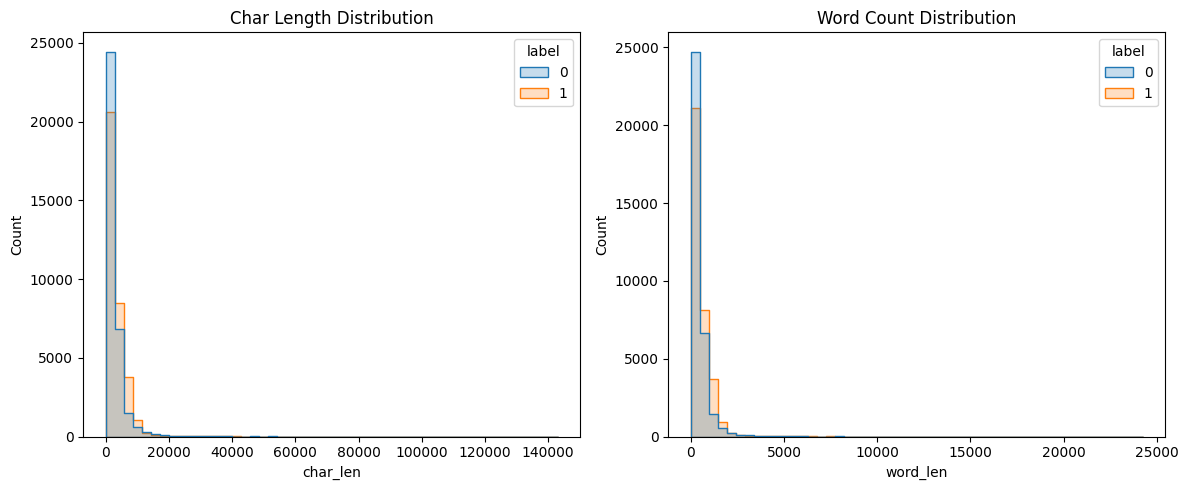

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df, x='char_len', hue='label', bins=50, element='step')
plt.title('Char Length Distribution')
plt.subplot(1,2,2)
sns.histplot(df, x='word_len', hue='label', bins=50, element='step')
plt.title('Word Count Distribution')
plt.tight_layout()
plt.show()

Biểu đồ histogram cho ta hình dung về sự phân bố độ dài của văn bản (theo ký tự và theo số từ) cho hai lớp:

1. **Đặc điểm chung**

   * Cả hai lớp đều có phân bố lệch phải (right skewed), tức là hầu hết bài nằm ở phần độ dài ngắn, rồi giảm dần tần suất khi độ dài tăng lên.
   * Cả hai biểu đồ đều có đuôi dài kéo tận các giá trị rất cao, nghĩa là vẫn có một số bài cực dài nhưng rất ít.

2. **So sánh Fake (label 0) vs True (label 1)**

   * Ở bên trái (độ dài nhỏ), cột của Fake thường cao hơn True, tức là bài giả chiếm tỉ lệ lớn hơn ở nhóm cực ngắn.
   * Phần đỉnh của Fake nằm ở khoảng vài trăm đến \~1 000 ký tự (tương đương vài chục đến vài trăm từ), còn True thì đỉnh dịch sang phải hơn, khoảng 1 000–2 000 ký tự (vài trăm từ).
   * Với độ dài trung bình cao hơn, True có nhiều bài dài hơn Fake—đỉnh và khối lượng phân bố của True kéo dài ra xa hơn bên phải so với Fake.

3. **Ý nghĩa**

   * Tin giả thường ngắn gọn, đôi khi chỉ vài câu, còn tin thật có xu hướng chi tiết hơn, dài hơn.
   * Vì thế "độ dài văn bản" là một feature có khả năng phân biệt hai lớp: bài quá ngắn (ví dụ < 100 từ) rất có thể là tin giả, trong khi bài dài hơn (vài trăm từ trở lên) có nhiều khả năng là tin thật.

Kết luận: histograms cho thấy sự khác biệt rõ ràng về phân bố độ dài giữa hai lớp, và chúng gợi ý rằng ta có thể đưa thêm các đặc trưng liên quan đến độ dài (char\_len, word\_len, các ngưỡng cắt) vào mô hình để cải thiện hiệu quả phân loại.


#### Boxplot

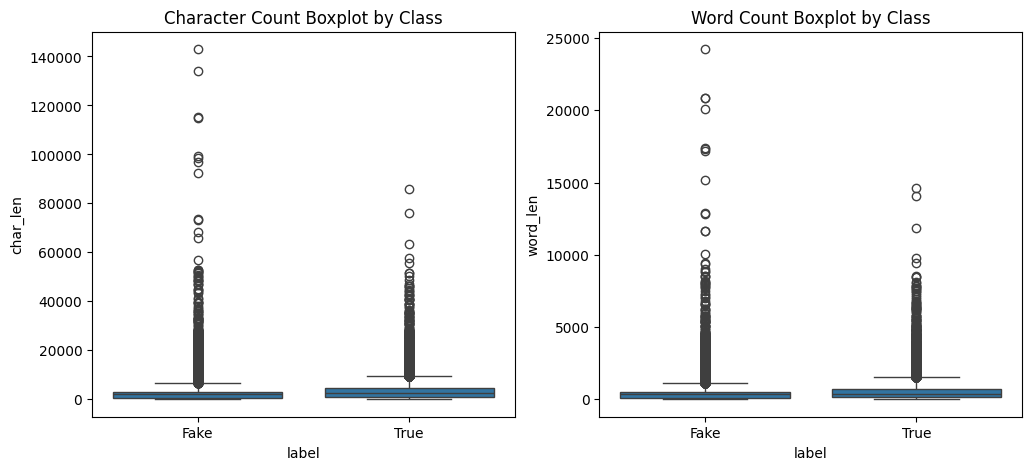

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='label', y='char_len', data=df)
plt.xticks([0,1], ['Fake','True'])
plt.title('Character Count Boxplot by Class')
plt.subplot(1,2,2)
sns.boxplot(x='label', y='word_len', data=df)
plt.xticks([0,1], ['Fake','True'])
plt.title('Word Count Boxplot by Class')
plt.show()

Từ boxplot, ta có thêm một số nhận xét về dữ liệu:

1. **IQR và median**

   * Cả hai lớp đều có median và IQR tương tự với những con số quan sát được ở bảng thống kê tóm tắt: IQR của lớp True cao hơn so với lớp Fake, khẳng định lớp True dài hơn Fake ở phần trung tâm dữ liệu.

2. **Outliers**

   * Từ hình ảnh được trực quan hoá, ta thấy cả hai lớp đều có rất nhiều outliers:

     * Lớp Fake có số outliers ký tự vượt 100 000—những bài cực dài rất hiếm.
     * Lớp True cũng có outliers nhưng ít hơn.
   * Điều này gợi ý rằng cần xem xét cắt bớt hoặc xử lý outliers trước khi train mô hình, để tránh ảnh hưởng quá đáng vào TF-IDF hoặc các thuật toán nhạy với giá trị lớn.

3. **Phân biệt lớp**

   * Mặc dù có nhiều outliers, nhưng IQR của hai lớp vẫn tách biệt rõ:

     * Fake: IQR char\_len khoảng \[\~600, \~3 000], word\_len khoảng \[\~100, \~500].
     * True: IQR char\_len khoảng \[\~1 100, \~4 400], word\_len khoảng \[\~180, \~725].
   * Điều này cho thấy feature "độ dài văn bản" có thể là một đặc trưng tốt để phân biệt hai lớp, vì khoảng IQR của chúng gần như không chồng nhiều lên nhau.

**Kết luận**:

Boxplot nhấn mạnh thêm rằng:

* Tin thật có độ dài tập trung về giá trị lớn hơn tin giả.
* Cần xử lý outliers trước khi vector hóa hoặc thêm feature length.
* Độ dài văn bản là feature tiềm năng để cải thiện mô hình phân loại.


## Data Processing

Trong bước này, ta sẽ xử lý dữ liệu để có thể đưa vào các mô hình phân loại:
* Loại bỏ một số outlier dựa trên percentiles (9-92 %) của cả `char_len` và `word_len`

Sau đó, ta có thể:
* Làm sạch văn bản (clean text):
  * Lowercasing
  * Loại bỏ URL và HTML tags
* Tokenization (cho các mô hình transformer) & Stop‐word removal
* Vector hoá bằng Tf-idf để chuẩn bị đưa vào mô hình Machine Learning

### Loại bỏ outliers

In [ ]:
lower_pct = 0.09
upper_pct = 0.92
char_low, char_high = df['char_len'].quantile([lower_pct, upper_pct])
word_low, word_high = df['word_len'].quantile([lower_pct, upper_pct])
print(f"Removing char_len outside [{char_low:.0f}, {char_high:.0f}] and word_len outside [{word_low:.0f}, {word_high:.0f}]")
# Filter
mask = (
    df['char_len'].between(char_low, char_high) &
    df['word_len'].between(word_low, word_high)
)
df = df[mask].reset_index(drop=True)
print(f"Samples after outlier removal: {len(df)}")

Removing char_len outside [251, 6959] and word_len outside [41, 1159]
Samples after outlier removal: 56569


#### Histogram sau khi xử lý outliers

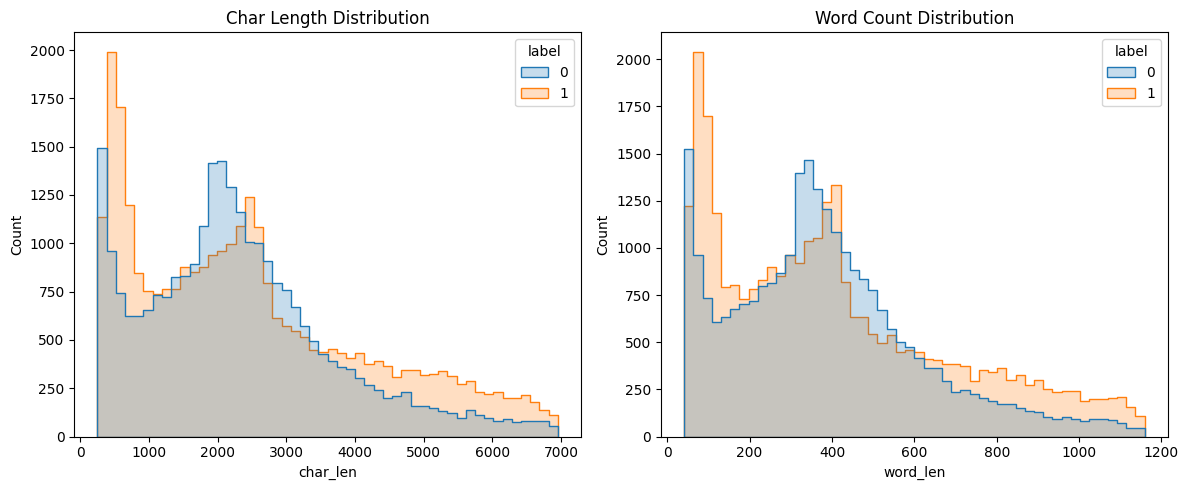

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df, x='char_len', hue='label', bins=50, element='step')
plt.title('Char Length Distribution')
plt.subplot(1,2,2)
sns.histplot(df, x='word_len', hue='label', bins=50, element='step')
plt.title('Word Count Distribution')
plt.tight_layout()
plt.show()

Có thể thấy hiện tại sau khi xử lý outlier, ta thấy rằng:
* Trước kia hist có khoảng (range) kéo dài hàng chục ngàn ký tự / hàng nghìn từ; giờ đuôi chỉ vươn tới ~8 000 ký tự và ~1 300 từ. Những giá trị cực đoan (vô cùng dài hoặc vô cùng ngắn) đã bị loại.
* Phân bố hai lớp giờ xịch hơn về biên độ giá trị: Fake chủ yếu nằm trong ~200–3 000 ký tự (tương đương ~20–500 từ), True trong ~500–4 000 ký tự (khoảng ~50–700 từ).
* Đỉnh của hai lớp vẫn khác nhau (đỉnh Fake nằm thấp hơn, True dịch sang phải) nhưng khoảng chung giữa chúng thu hẹp, giúp trực quan so sánh dễ hơn.
* Bỏ bớt cực đoan giúp TF‑IDF không bị ảnh hưởng bởi những bài quá dài hay quá ngắn (vốn có thể mang nhiều từ hiếm hoặc quá lặp).
* Việc này cũng làm rõ hơn khoảng phân biệt độ dài trung bình giữa fake và true, từ đó feature “length” có thể phát huy tác dụng tốt hơn.
* Cả hai biểu đồ vẫn lệch phải (right‑skewed), tức đa số bài ngắn hơn, số ít kéo dài hơn. Điều này phù hợp với thực tế: nhiều tiêu đề / tin ngắn, một số bài giải thích chi tiết.

**Kết luận**: bước lọc outliers đã làm cho phân phối độ dài gọn gàng, bớt “nhiễu” cực đoan nhưng vẫn giữ được khác biệt về trung bình và mode giữa Fake/True. Đây là tiền đề tốt để đưa feature độ dài vào mô hình hoặc tiến hành vector hóa TF‑IDF mà không phải lo xử lý giá trị ngoại lai nữa.

#### Boxplot sau khi xử lý outliers

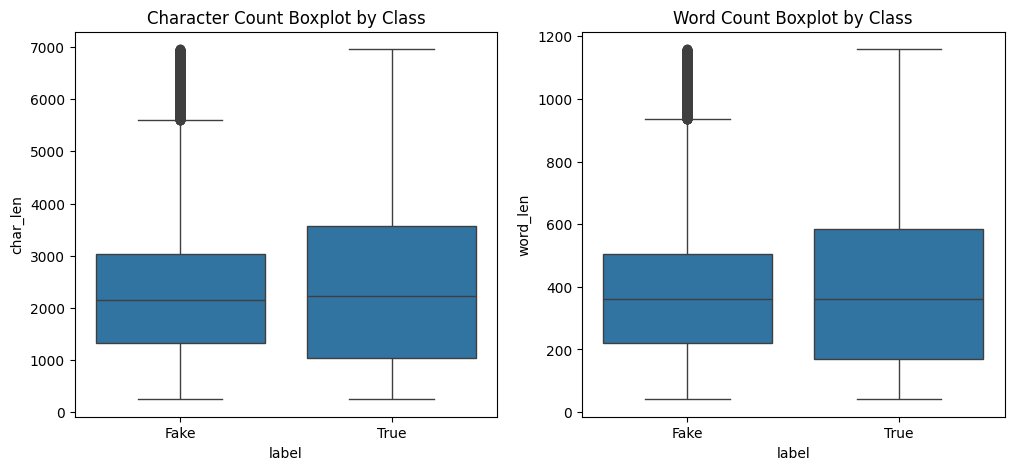

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='label', y='char_len', data=df)
plt.xticks([0,1], ['Fake','True'])
plt.title('Character Count Boxplot by Class')
plt.subplot(1,2,2)
sns.boxplot(x='label', y='word_len', data=df)
plt.xticks([0,1], ['Fake','True'])
plt.title('Word Count Boxplot by Class')
plt.show()

Dễ thấy rằng đã xoá được rất nhiều giá trị ngoại lai.

#### Kiểm tra lại phân phối lớp sau khi xử lý outliers

Class distribution:
label
0    26397
1    30172
Name: count, dtype: int64


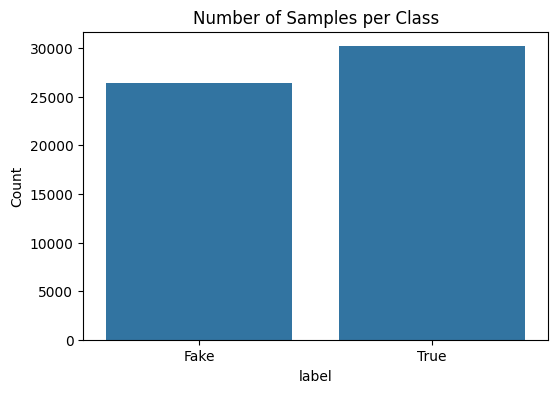

In [ ]:
class_counts = df['label'].value_counts().sort_index()
print("Class distribution:")
print(class_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0,1], ['Fake','True'])
plt.title('Number of Samples per Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# get stopwords list
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
stop_words = nlp.Defaults.stop_words

# 2. DatasetLoader cho Fake News

In [ ]:
def print_memory_usage(stage):
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 3)
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
    print(f"Memory usage at {stage}: {mem:.2f} GB")

class FakeNewsDatasetLoader:
    def __init__(self):

        self.train = None
        self.val = None
        self.test = None

    def load(self, df):

        train_df, test_df = train_test_split(
            df, test_size=0.2, stratify=df['label'], random_state=42
        )
        train_df, val_df = train_test_split(
            train_df, test_size=0.15, stratify=train_df['label'], random_state=42
        )

        def df_to_dict_safe(df):
            """Convert DataFrame to dict while handling numpy 2.x compatibility"""
            result = {}
            for col in df.columns:
                if df[col].dtype == 'object':
                    result[col] = df[col].astype(str).tolist()
                else:
                    result[col] = df[col].astype(int).tolist()
            return result

        self.train = Dataset.from_dict(df_to_dict_safe(train_df))
        self.val   = Dataset.from_dict(df_to_dict_safe(val_df))
        self.test  = Dataset.from_dict(df_to_dict_safe(test_df))

        del train_df, val_df, test_df; gc.collect()
        return self.train, self.val, self.test

# 3. Tiền xử lý văn bản
Làm sạch văn bản

In [ ]:
class Preprocessor:
    def __init__(self):
        self.html_tag = re.compile(r'<[^>]+>')
        self.whitespace = re.compile(r'\s+')

    def clean_text(self, texts):
        is_single = isinstance(texts, str)
        texts = [texts] if is_single else texts
        return [self._clean_single_text(text) for text in texts]

    def _clean_single_text(self, text):
        text = str(text)
        text = self.html_tag.sub('', text)
        text = self.whitespace.sub(' ', text)
        return text.strip().lower()

    def preprocess(self, dataset: Dataset) -> Dataset:
        return dataset.map(
            lambda x: {'text': self.clean_text(x['text'])},
            batched=True,
            batch_size=1000,
            num_proc=5,
            desc="Cleaning texts"
        )


# 4. Tokenizer (cho các mô hình transformer)

In [ ]:
class Tokenizer:
    def __init__(self, model_name, max_length):
        self.model_name = model_name
        self.max_length = max_length

        if 'distilbert' in model_name:
            self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        elif 'bert' in model_name:
            self.tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
        elif 'xlnet' in model_name:
            self.tokenizer = XLNetTokenizer.from_pretrained(model_name)
            self.tokenizer.padding_side = 'left'
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def tokenize(self, dataset: Dataset) -> Dataset:
        if 'label' in dataset.column_names:
            if 'distilbert' in self.model_name or 'bert' in self.model_name:
                dataset = dataset.rename_column("label", "labels")
            elif 'xlnet' in self.model_name:
                pass

        # Sử dụng num_proc=1 để ổn định
        tokenized = dataset.map(
            self._tokenize_batch,
            batched=True,
            remove_columns=['text'],
            num_proc=5,
            desc="Tokenizing texts"
        )

        if 'distilbert' in self.model_name or 'bert' in self.model_name:
            required_columns = ['input_ids', 'attention_mask', 'labels']
        else:  # XLNet
            required_columns = ['input_ids', 'attention_mask', 'label']

        tokenized.set_format(
            'torch',
            columns=required_columns,
            output_all_columns=False
        )

        return tokenized

    def _tokenize_batch(self, examples):
        return self.tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_token_type_ids=('bert' in self.model_name)
        )

# 5. DataLoader Creator (cho transformer models)

In [ ]:
class DataLoaderCreator:
    def __init__(self, hp):
        self.batch_size = hp.batch_size
        self.shuffle_flags = {
            'train': True,
            'val': False,
            'test': False
        }

    def create(self, datasets):
        return {
            split: DataLoader(
                dataset,
                batch_size=self.batch_size,
                shuffle=self.shuffle_flags[split],
                num_workers=0,
                pin_memory=True
            )
            for split, dataset in datasets.items()
        }

# 6. Xây dựng mô hình

In [ ]:
class ModelBuilder:
    @staticmethod
    def build(hp):
        # Xử lý các mô hình transformer
        if 'distilbert' in hp.model_name:
            try:
                model = DistilBertForSequenceClassification.from_pretrained(
                    hp.model_name,
                    num_labels=1
                )
            except OSError:
                model = DistilBertForSequenceClassification.from_pretrained(
                    hp.model_name,
                    num_labels=1,
                    from_tf=True
                )
            return model
        elif 'bert' in hp.model_name:
            model = BertForSequenceClassification.from_pretrained(
                hp.model_name,
                num_labels=1,
                hidden_dropout_prob=hp.dropout_rate,
                attention_probs_dropout_prob=hp.dropout_rate
            )
            return model
        elif 'xlnet' in hp.model_name:
            model = XLNetForSequenceClassification.from_pretrained(
                hp.model_name,
                num_labels=1,
                dropout=hp.dropout_rate
            )
            return model

        # Xử lý các mô hình TF-IDF + Machine Learning
        elif 'tfidf' in hp.model_name:
            vectorizer = TfidfVectorizer(
                max_features=hp.tfidf_max_features,
                ngram_range=(1, 2),
                stop_words='english'
            )

            if 'lr' in hp.model_name:
                classifier = LogisticRegression(
                    max_iter=1000,
                    C=hp.tfidf_c,
                    random_state=2305,
                    n_jobs=-1  # Sử dụng tất cả cores
                )
            elif 'svm' in hp.model_name:
                classifier = SVC(
                    C=hp.tfidf_c,
                    kernel='linear',
                    probability=True,
                    random_state=2305
                )
            elif 'rf' in hp.model_name:
                classifier = RandomForestClassifier(
                    n_estimators=100,
                    random_state=2305,
                    n_jobs=-1  # Sử dụng tất cả cores
                )
            else:
                raise ValueError(f"Unknown TF-IDF model: {hp.model_name}")

            return Pipeline([
                ('tfidf', vectorizer),
                ('clf', classifier)
            ])

        else:
            raise ValueError(f"Unsupported model type: {hp.model_name}")

# 7. Hyperparameters

In [ ]:
class Hyperparameters:
    def __init__(self):
        self.batch_size = 64
        self.max_length = 128
        self.epochs = 10
        self.learning_rate = 2e-5
        self.weight_decay = 0.01
        self.warmup_steps = 100
        self.patience = 2
        self.max_grad_norm = 1.0
        self.dropout_rate = 0.2
        self.tfidf_max_features = 5000
        self.tfidf_c = 1.0


# 8. Quy trình training cho transformer models

In [ ]:
class TransformerTrainer:
    def __init__(self, model, hp, train_loader, val_loader):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.hp = hp
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.best_val_acc = 0
        self.early_stop_counter = 0
        self.patience = hp.patience

        # Setup optimizer and scheduler
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=hp.learning_rate,
            weight_decay=hp.weight_decay
        )

        total_steps = len(train_loader) * hp.epochs
        self.scheduler = torch.optim.lr_scheduler.LinearLR(
            self.optimizer,
            start_factor=0.1,
            total_iters=hp.warmup_steps
        )

    def train(self):
        for epoch in range(self.hp.epochs):
            # In dòng Epoch
            print(f"\nEpoch {epoch+1}/{self.hp.epochs}")

            # ——— Training loop với tqdm ———
            self.model.train()
            total_loss, total_correct = 0.0, 0
            train_bar = tqdm(self.train_loader, desc="Training", unit="batch")
            for batch in train_bar:
                loss, correct = self._process_batch(batch, train=True)
                total_loss += loss
                total_correct += correct
                # Cập nhật postfix (tuỳ chọn)
                # train_bar.set_postfix(
                #     loss=f"{total_loss/(train_bar.n):.4f}",
                #     acc=f"{total_correct/((train_bar.n)*batch['input_ids'].size(0)):.4f}"
                # )
            avg_train_loss = total_loss / len(self.train_loader)
            train_acc = total_correct / len(self.train_loader.dataset)

            # ——— Validation loop với tqdm ———
            self.model.eval()
            val_loss, val_correct = 0.0, 0
            val_bar = tqdm(self.val_loader, desc="Validation", unit="batch")
            with torch.no_grad():
                for batch in val_bar:
                    loss, correct = self._process_batch(batch, train=False)
                    val_loss += loss
                    val_correct += correct
                    # val_bar.set_postfix(
                    #     loss=f"{val_loss/(val_bar.n):.4f}",
                    #     acc=f"{val_correct/((val_bar.n)*batch['input_ids'].size(0)):.4f}"
                    # )
            avg_val_loss = val_loss / len(self.val_loader)
            val_acc = val_correct / len(self.val_loader.dataset)

            # In kết quả epoch
            print(f"[Train] Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f}")
            print(f"[Val]   Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f}")

            # Early stopping & lưu model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.early_stop_counter = 0
                self.best_model_path = f"best_{self.hp.model_name.replace('/', '_')}.pt"
                torch.save(self.model.state_dict(), self.best_model_path)
                print(f"New best model saved (Val Acc: {val_acc:.4f})")
            else:
                self.early_stop_counter += 1
                print(f"No improvement for {self.early_stop_counter}/{self.patience} epochs")
                if self.early_stop_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if not hasattr(self, 'best_model_path'):
            self.best_model_path = f"final_{self.hp.model_name.replace('/', '_')}.pt"
            torch.save(self.model.state_dict(), self.best_model_path)
            print(f"Saved final model to {self.best_model_path}")

        print_memory_usage("After training")

    def _process_batch(self, batch, train):
        inputs = {
            'input_ids': batch['input_ids'].to(self.device),
            'attention_mask': batch['attention_mask'].to(self.device),
            'labels': batch.get('labels', batch.get('label')).to(self.device).float()
        }
        outputs = self.model(**inputs)
        loss = outputs.loss if hasattr(outputs, 'loss') else nn.BCEWithLogitsLoss()(outputs.logits.squeeze(), inputs['labels'])

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), self.hp.max_grad_norm)
            self.optimizer.step(); self.optimizer.zero_grad(); self.scheduler.step()

        logits = outputs.logits
        preds = (torch.sigmoid(logits) > 0.5).int().squeeze()
        correct = (preds == inputs['labels'].int()).sum().item()

        return loss.item(), correct

# 9. Quy trình training cho TF-IDF + ML models

In [ ]:
class TFIDFTrainer:
    def __init__(self, model, hp, X_train, y_train, X_val, y_val):
        self.model = model
        self.hp = hp
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.best_model = None

    def train(self):
        print("\nTraining TF-IDF model...")
        self.model.fit(self.X_train, self.y_train)
        val_acc = self.model.score(self.X_val, self.y_val)
        print(f"[Validation] Accuracy: {val_acc:.4f}")
        self.best_model = self.model

    def evaluate(self, X_test, y_test):
        test_acc = self.best_model.score(X_test, y_test)
        y_pred = self.best_model.predict(X_test)

        print("\nTest Results:")
        print(f"Accuracy: {test_acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        return {
            'accuracy': test_acc,
            'report': classification_report(y_test, y_pred, output_dict=True)
        }

# 10. Evaluator (cho transformer models)

In [ ]:
class TransformerEvaluator:
    @staticmethod
    def evaluate(model, test_loader, device, model_name):
        if 'distilbert' in model_name or 'bert' in model_name:
            label_key = 'labels'
        else:  # XLNet
            label_key = 'label'

        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                inputs = {
                    'input_ids': batch['input_ids'].to(device),
                    'attention_mask': batch['attention_mask'].to(device)
                }
                labels = batch[label_key].to(device)
                outputs = model(**inputs)

                logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).int().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        report_dict = classification_report(all_labels, all_preds, output_dict=True)
        acc = accuracy_score(all_labels, all_preds)
        return {
            'accuracy': acc,
            'report': report_dict,
            'preds': all_preds,
            'labels': all_labels,
            'probs': all_probs
        }

# 11. Tích hợp cả hai phương pháp

In [ ]:
def get_all_sentences(dataset) -> List[str]:

    all_sentence = []

    for i in range(len(dataset)):

        sentence = dataset[i]['text']
        all_sentence.append(sentence)

    return all_sentence

def n_gram_word_frequency(sentence_list: list, n: int) -> pd.DataFrame:

    count_vectorizer = CountVectorizer(ngram_range=(n,n), stop_words=list(stop_words))
    n_grams_feature_vector = count_vectorizer.fit_transform(sentence_list)
    feature_names = count_vectorizer.get_feature_names_out()
    return n_grams_feature_vector, feature_names

In [ ]:
# Explore top words and prepare data for training phase
def prepare_clean_and_tfidf(hp):

    # Prepare data and clean text
    loader = FakeNewsDatasetLoader()
    raw_train, raw_val, raw_test = loader.load(df)
    prep = Preprocessor()
    train_data = prep.preprocess(raw_train)
    val_data = prep.preprocess(raw_val)
    test_data = prep.preprocess(raw_test)

    # Explore top 10 most popular and rarest words using uni-gram (stopwords removed)
    list_all_sentence: list = get_all_sentences(train_data) + get_all_sentences(val_data) + get_all_sentences(test_data)
    print(f"Texts within the dataset: {len(list_all_sentence)}")
    print(f"Example text: {list_all_sentence[7]}")

    n_grams_feature_vector, feature_names = n_gram_word_frequency(sentence_list=list_all_sentence, n=1)
    counts = np.asarray(n_grams_feature_vector.sum(axis=0)).ravel()
    word_dict = dict(zip(feature_names, counts))

    pop_10 = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    print("\nTop 10 từ phổ biến nhất (uni‑gram, đã loại bỏ stopwords):")
    for rank, (word, freq) in enumerate(pop_10, start=1):
        print(f"{rank}. '{word}': {freq} lần")

    rare_10 = sorted(word_dict.items(), key=lambda x: x[1])[:10]

    print("\nTop 10 từ hiếm nhất (uni‑gram, đã loại bỏ stopwords):")
    for rank, (word, freq) in enumerate(rare_10, start=1):
        print(f"{rank}. '{word}': {freq} lần")

    del list_all_sentence, n_grams_feature_vector, feature_names, counts, word_dict; gc.collect()

    # Prepare data to train ML model using Tfidf vectorize
    X_train, y_train = train_data['text'], train_data['label']
    X_val,   y_val   = val_data['text'],   val_data['label']
    X_test,  y_test  = test_data['text'],  test_data['label']

    return (X_train, y_train, X_val, y_val, X_test, y_test), train_data, val_data, test_data

# Run experiments for ML models using Tfidf vectorize
def run_tfidf_experiments(hp, tfidf_data):

    X_train, y_train, X_val, y_val, X_test, y_test = tfidf_data
    results = {}

    for model_name in ['tfidf_lr', 'tfidf_rf']:

        hp.model_name = model_name
        hp.tfidf_c = 0.1 if 'lr' in model_name or 'svm' in model_name else 1.0
        model = ModelBuilder.build(hp)
        trainer = TFIDFTrainer(model, hp, X_train, y_train, X_val, y_val)
        trainer.train()
        results[model_name] = trainer.evaluate(X_test, y_test)

    return results

# Run experiments for transformer models
def run_transformer_experiments(hp, train_data, val_data, test_data):

    results = {}
    for model_name in ['bert-base-uncased','distilbert-base-uncased','xlnet-base-cased', ]:

        hp.model_name = model_name
        if 'distilbert' in model_name:
            hp.batch_size = 32

        # Tokenize cleaned data
        tokenizer = Tokenizer(model_name, hp.max_length)
        print("\nTokenizing data...")
        train = tokenizer.tokenize(train_data)
        val   = tokenizer.tokenize(val_data)
        test  = tokenizer.tokenize(test_data)
        print_memory_usage("After tokenization")

        # Create loaders and train
        loader_creator = DataLoaderCreator(hp)
        dataloaders = loader_creator.create({
            'train': train,
            'val': val,
            'test': test
        })

        print("\nDataLoaders created:")
        print(f"Train batches: {len(dataloaders['train'])}")
        print(f"Val batches: {len(dataloaders['val'])}")
        print(f"Test batches: {len(dataloaders['test'])}")

        # Build model
        model = ModelBuilder.build(hp)
        print(f"\nModel architecture: {model.__class__.__name__}")

        # Training
        trainer = TransformerTrainer(
            model=model,
            hp=hp,
            train_loader=dataloaders['train'],
            val_loader=dataloaders['val']
        )

        print("\nStarting training...")
        trainer.train()

        # Evaluating
        if trainer.best_model_path and os.path.exists(trainer.best_model_path):
            model.load_state_dict(torch.load(trainer.best_model_path))

        print("\nEvaluating on test set...")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        res = TransformerEvaluator.evaluate(
            model=model,
            test_loader=dataloaders['test'],
            device=device,
            model_name=hp.model_name
        )

        results[model_name] = res

        print("\nTest Results:")
        print(f"Accuracy: {res['accuracy']:.4f}")
        print("Classification Report:")
        print(classification_report(
            res['labels'],
            res['preds'],
            target_names=['Fake','True'],
            digits=4
        ))

        # Plot Confusion Matrix
        cm = confusion_matrix(res['labels'], res['preds'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=['Fake','True'])
        fig_cm, ax_cm = plt.subplots()
        disp.plot(ax=ax_cm, values_format='d')
        ax_cm.set_title(f"Confusion Matrix: {model_name}")
        plt.show()

        # Plot ROC Curve and AUC
        fpr, tpr, _ = roc_curve(res['labels'], res['probs'])
        roc_auc = auc(fpr, tpr)
        fig_roc, ax_roc = plt.subplots()
        ax_roc.plot(fpr, tpr)
        ax_roc.plot([0,1], [0,1])
        ax_roc.set_xlabel('False Positive Rate')
        ax_roc.set_ylabel('True Positive Rate')
        ax_roc.set_title(f"ROC Curve: {model_name} (AUC = {roc_auc:.4f})")
        plt.show()

    return results

# 12. Hàm main

GPU Memory allocated: 0.00 MB
Memory usage at Before loading data: 1.87 GB


Cleaning texts (num_proc=5):   0%|          | 0/38466 [00:00<?, ? examples/s]

Cleaning texts (num_proc=5):   0%|          | 0/6789 [00:00<?, ? examples/s]

Cleaning texts (num_proc=5):   0%|          | 0/11314 [00:00<?, ? examples/s]

Texts within the dataset: 56569
Example text: if you want to know the likely result of next month’s french presidential election run off, just look at how the markets responded. the euro and the french markets both jumped dramatically. [and this has nothing to do with the underlying strength of the sclerotic, unionised, statist, overtaxed, unproductive french economy or, indeed, with the future of the doomed euro. it was simply a case of the status quo breathing a sigh of relief that it was going to be business as usual, after all: emmanuel macron, the de facto establishment candidate is now pretty much a for the french presidency his rival, marine le pen doesn’t stand a prayer — of that the establishment will make sure. but brexit. but donald trump … nope: i’m afraid those arguments just don’t wash in this case. yes, it’s true the world is in the throes of a revolution in which the globalist elite is gradually being overthrown by populist, nationalist rebels. but it won’t happen yet i

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(



Top 10 từ phổ biến nhất (uni‑gram, đã loại bỏ stopwords):
1. 'said': 152048 lần
2. 'trump': 147659 lần
3. 'president': 60973 lần
4. 'people': 52516 lần
5. 'new': 40803 lần
6. 'clinton': 40034 lần
7. 'state': 39350 lần
8. 'donald': 32139 lần
9. 'states': 30620 lần
10. 'like': 30388 lần

Top 10 từ hiếm nhất (uni‑gram, đã loại bỏ stopwords):
1. '00000017': 1 lần
2. '00000031': 1 lần
3. '000048': 1 lần
4. '00006': 1 lần
5. '000063': 1 lần
6. '00007': 1 lần
7. '0001': 1 lần
8. '0002': 1 lần
9. '000202': 1 lần
10. '000205': 1 lần
GPU Memory allocated: 0.00 MB
Memory usage at After loading and preprocessing data: 2.33 GB

Training TF-IDF model...
[Validation] Accuracy: 0.9113

Test Results:
Accuracy: 0.9029
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5279
           1       0.91      0.91      0.91      6035

    accuracy                           0.90     11314
   macro avg       0.90      0.90      0.90     

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Tokenizing data...


Tokenizing texts (num_proc=5):   0%|          | 0/38466 [00:00<?, ? examples/s]

Tokenizing texts (num_proc=5):   0%|          | 0/6789 [00:00<?, ? examples/s]

Tokenizing texts (num_proc=5):   0%|          | 0/11314 [00:00<?, ? examples/s]

GPU Memory allocated: 0.00 MB
Memory usage at After tokenization: 2.63 GB

DataLoaders created:
Train batches: 602
Val batches: 107
Test batches: 177


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model architecture: BertForSequenceClassification

Starting training...

Epoch 1/10


Training:   0%|          | 0/602 [00:00<?, ?batch/s]

Validation:   0%|          | 0/107 [00:00<?, ?batch/s]

[Train] Loss: 0.0660 | Acc: 0.6985
[Val]   Loss: 0.0152 | Acc: 0.9462
New best model saved (Val Acc: 0.9462)

Epoch 2/10


Training:   0%|          | 0/602 [00:00<?, ?batch/s]

Validation:   0%|          | 0/107 [00:00<?, ?batch/s]

[Train] Loss: 0.0151 | Acc: 0.7407
[Val]   Loss: 0.0127 | Acc: 0.5340
No improvement for 1/2 epochs

Epoch 3/10


Training:   0%|          | 0/602 [00:00<?, ?batch/s]

Validation:   0%|          | 0/107 [00:00<?, ?batch/s]

[Train] Loss: 0.0090 | Acc: 0.7471
[Val]   Loss: 0.0154 | Acc: 0.8851
No improvement for 2/2 epochs
Early stopping at epoch 3
GPU Memory allocated: 1271.27 MB
Memory usage at After training: 3.23 GB

Evaluating on test set...


Evaluating:   0%|          | 0/177 [00:00<?, ?it/s]


Test Results:
Accuracy: 0.9433
Classification Report:
              precision    recall  f1-score   support

        Fake     0.9981    0.8801    0.9354      5279
        True     0.9049    0.9985    0.9494      6035

    accuracy                         0.9433     11314
   macro avg     0.9515    0.9393    0.9424     11314
weighted avg     0.9484    0.9433    0.9429     11314



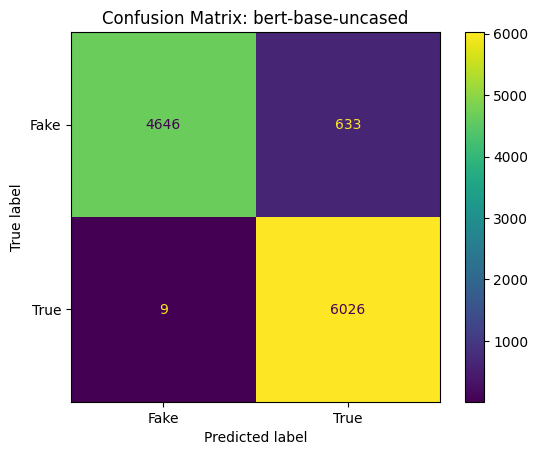

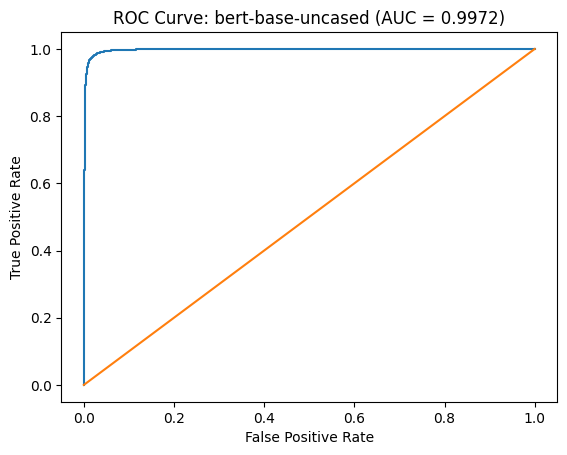

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


Tokenizing data...


Tokenizing texts (num_proc=5):   0%|          | 0/38466 [00:00<?, ? examples/s]

Tokenizing texts (num_proc=5):   0%|          | 0/6789 [00:00<?, ? examples/s]

Tokenizing texts (num_proc=5):   0%|          | 0/11314 [00:00<?, ? examples/s]

GPU Memory allocated: 1271.27 MB
Memory usage at After tokenization: 3.40 GB

DataLoaders created:
Train batches: 1203
Val batches: 213
Test batches: 354


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model architecture: DistilBertForSequenceClassification

Starting training...

Epoch 1/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0374 | Acc: 0.7084
[Val]   Loss: 0.0167 | Acc: 0.7584
New best model saved (Val Acc: 0.7584)

Epoch 2/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0096 | Acc: 0.7332
[Val]   Loss: 0.0126 | Acc: 0.7496
No improvement for 1/2 epochs

Epoch 3/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0056 | Acc: 0.7412
[Val]   Loss: 0.0180 | Acc: 0.6105
No improvement for 2/2 epochs
Early stopping at epoch 3
GPU Memory allocated: 786.11 MB
Memory usage at After training: 3.52 GB

Evaluating on test set...


Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Test Results:
Accuracy: 0.7614
Classification Report:
              precision    recall  f1-score   support

        Fake     1.0000    0.4887    0.6566      5279
        True     0.6910    1.0000    0.8173      6035

    accuracy                         0.7614     11314
   macro avg     0.8455    0.7444    0.7369     11314
weighted avg     0.8352    0.7614    0.7423     11314



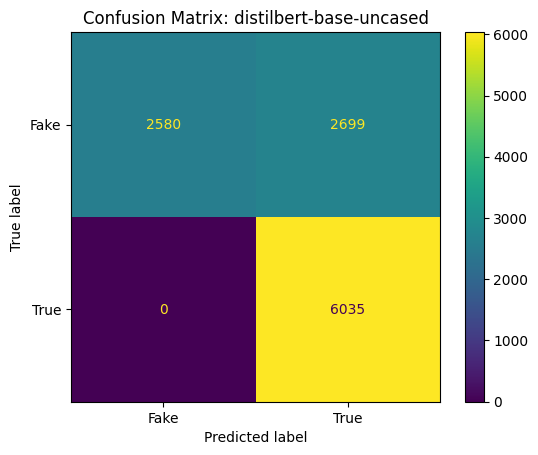

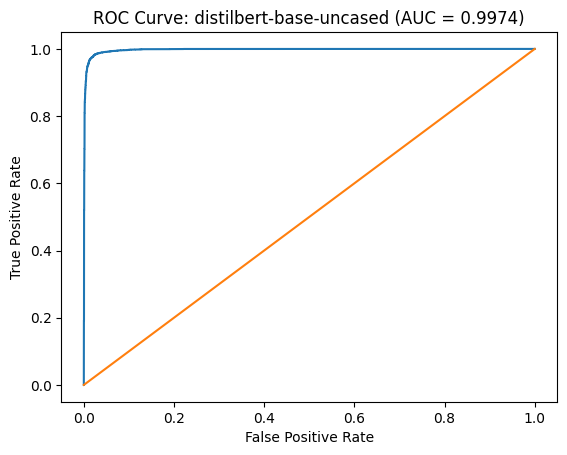

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]


Tokenizing data...


Tokenizing texts (num_proc=5):   0%|          | 0/38466 [00:00<?, ? examples/s]

Tokenizing texts (num_proc=5):   0%|          | 0/6789 [00:00<?, ? examples/s]

Tokenizing texts (num_proc=5):   0%|          | 0/11314 [00:00<?, ? examples/s]

GPU Memory allocated: 786.11 MB
Memory usage at After tokenization: 3.57 GB

DataLoaders created:
Train batches: 1203
Val batches: 213
Test batches: 354


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model architecture: XLNetForSequenceClassification

Starting training...

Epoch 1/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0545 | Acc: 0.7096
[Val]   Loss: 0.0145 | Acc: 0.5460
New best model saved (Val Acc: 0.5460)

Epoch 2/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0167 | Acc: 0.7320
[Val]   Loss: 0.0125 | Acc: 0.9658
New best model saved (Val Acc: 0.9658)

Epoch 3/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0109 | Acc: 0.7367
[Val]   Loss: 0.0165 | Acc: 0.9685
New best model saved (Val Acc: 0.9685)

Epoch 4/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0089 | Acc: 0.7404
[Val]   Loss: 0.0140 | Acc: 0.5334
No improvement for 1/2 epochs

Epoch 5/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0067 | Acc: 0.7419
[Val]   Loss: 0.0131 | Acc: 0.9866
New best model saved (Val Acc: 0.9866)

Epoch 6/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0061 | Acc: 0.7433
[Val]   Loss: 0.0114 | Acc: 0.9692
No improvement for 1/2 epochs

Epoch 7/10


Training:   0%|          | 0/1203 [00:00<?, ?batch/s]

Validation:   0%|          | 0/213 [00:00<?, ?batch/s]

[Train] Loss: 0.0050 | Acc: 0.7457
[Val]   Loss: 0.0106 | Acc: 0.9856
No improvement for 2/2 epochs
Early stopping at epoch 7
GPU Memory allocated: 1378.91 MB
Memory usage at After training: 3.58 GB

Evaluating on test set...


Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Test Results:
Accuracy: 0.9848
Classification Report:
              precision    recall  f1-score   support

        Fake     0.9948    0.9725    0.9835      5279
        True     0.9764    0.9955    0.9859      6035

    accuracy                         0.9848     11314
   macro avg     0.9856    0.9840    0.9847     11314
weighted avg     0.9850    0.9848    0.9848     11314



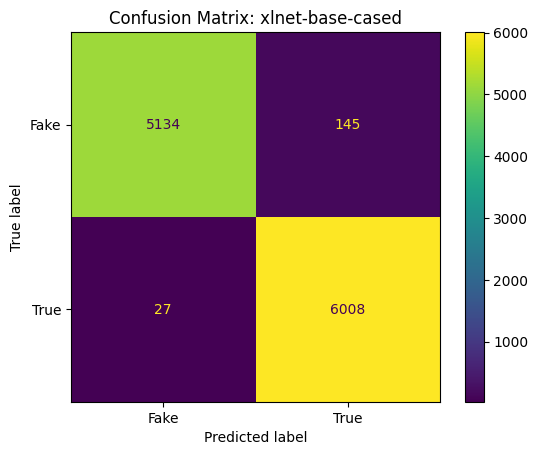

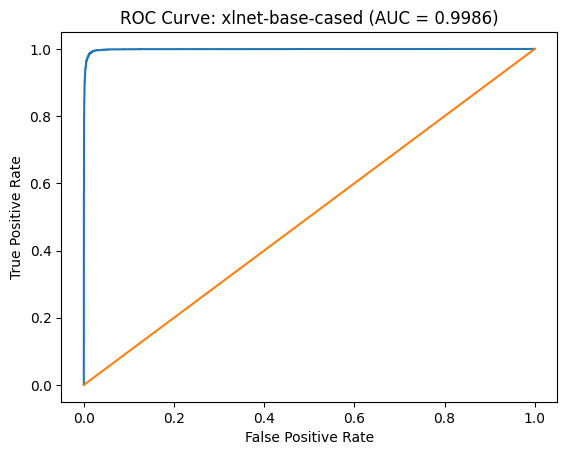



SUMMARY OF ALL MODEL PERFORMANCES

tfidf_lr:
Accuracy: 0.9029
F1-Score (Fake): 0.8959
F1-Score (True): 0.9090

tfidf_rf:
Accuracy: 0.9213
F1-Score (Fake): 0.9139
F1-Score (True): 0.9276

bert-base-uncased:
Accuracy: 0.9433
F1-Score (Fake): 0.9354
F1-Score (True): 0.9494

distilbert-base-uncased:
Accuracy: 0.7614
F1-Score (Fake): 0.6566
F1-Score (True): 0.8173

xlnet-base-cased:
Accuracy: 0.9848
F1-Score (Fake): 0.9835
F1-Score (True): 0.9859


In [ ]:
if __name__ == '__main__':

    hp = Hyperparameters()
    print_memory_usage("Before loading data")
    tfidf_data, train_data, val_data, test_data = prepare_clean_and_tfidf(hp)
    print_memory_usage("After loading and preprocessing data")
    all_tfidf = run_tfidf_experiments(hp, tfidf_data)
    all_trans = run_transformer_experiments(hp, train_data, val_data, test_data)
    # merge and print summary
    all_results = {**all_tfidf, **all_trans}
    # Báo cáo tổng hợp kết quả
    print("\n\n" + "="*60)
    print("SUMMARY OF ALL MODEL PERFORMANCES")
    print("="*60)
    for model_name, results in all_results.items():
        if results:
            print(f"\n{model_name}:")
            print(f"Accuracy: {results['accuracy']:.4f}")
            if 'report' in results and isinstance(results['report'], dict):
                # Xử lý báo cáo cho transformer và TF-IDF
                if '0' in results['report'] and '1' in results['report']:
                    print(f"F1-Score (Fake): {results['report']['0']['f1-score']:.4f}")
                    print(f"F1-Score (True): {results['report']['1']['f1-score']:.4f}")
                elif 'macro avg' in results['report']:
                    print(f"F1-Score (Macro): {results['report']['macro avg']['f1-score']:.4f}")
